In [1]:
import pandas as pd
import re

## Armado de dataset para entrenamiento del modelo

Se usan ventanas de tiempo de 6 meses para agrupar los datos y predecir la baja dentro de los próximos 6

Training: 
- 1 a 6
- 2 a 7
- 3 a 8

Optimization
- 4 a 9

Validation
- 5 a 10

Test
- 6 a 11
- 7 a 12

In [2]:
df = pd.read_feather('../../../../data/processed/merged_data_18_periods.feather')

### Detectamos inconsistencias: Del periodo 1 a 3 no hay cargados valores para SITUACION_PP

<h4 style="color:red" > Se soluciona agregando las columnas al dataframe lleno de nulls. REVISAR EL SCRIPT ORIGINAL A FUTURO</h4>

In [3]:
import numpy as np

for col in ['1_SITUACION_PP','2_SITUACION_PP','3_SITUACION_PP']:
    df[col] = np.nan

Verificamos la distribucion de periodos de baja

In [4]:
df["periodo_baja"].value_counts().sort_index().plot.bar()

In [5]:
df["CIF_ID"].isna().sum()

0

### Script de agrupación de registros de acuerdo a las ventanas temporales. El test está en *1. Test to arrange datasets by time periods*

In [14]:
# Buscamos las features que son periódicas
periodic_cols = set([''.join([s for s in col if not s.isdigit()]) for col in df[[col for col in df.columns if re.search(f'\d', col)]].columns])

# Armamos otro dataframe con todas las features que no son temporales
non_periodic_cols = [col for col in df.columns if not any(char.isdigit() for char in col)]


# Definimos ventana inicial
w_low = 1
w_top = 6
further_periods = 6

final_df = pd.DataFrame()

while(w_low < 8):
    print(f"----------TIME WINDOW: {w_low} a {w_top}-----------")
    # Armamos todo el nuevo dataset del periodo en grouped_df
    grouped_df = df[non_periodic_cols].copy(deep=True)

    #Seleccionamos las features del periodo
    print("Seleccionando features por periodo...                       ", end="\r", flush=True)
    for pcol in periodic_cols:
        regex_range = "|".join([str(i) for i in range(w_low, w_top+1)])
        regex = f'{pcol}({regex_range})$|^({regex_range}){pcol}'
        columns = [col for col in df.columns if re.search(regex, col)]
        grouped_df[[f"{i}_{pcol}" for i in range(1, 7)]] = df[columns]

    # Buscamos los clientes que no tienen polizas en el periodo analizado
    print("Buscando clientes sin polizas...                       ", end="\r", flush=True)
    grouped_df = grouped_df[grouped_df["hist_polizas"].str.split(" ", expand=True).iloc[:,w_low-1:w_top].astype(float).sum(axis=1) > 0]
    
    # Buscamos las polizas que ya se dieron de baja en el periodo analizado
    print("Buscando clientes que ya se dieron de baja...                  ", end="\r", flush=True)
    grouped_df = grouped_df[~grouped_df["periodo_baja"].between(1, w_top)]
    
    # Preparamos columnas de pólizas por período
    print("Preparando pólizas por períodos...                             ", end="\r", flush=True)
    grouped_df[[f"polizas_{i}" for i in range(1, 7)]] = grouped_df["hist_polizas"].str.split(" ", expand=True).iloc[:,w_low-1:w_top].astype(float)
    
    # Marcamos periodo de baja
    print("Creando flag de CLTP...                           ", end="\r", flush=True)
    grouped_df["CLTP"] = grouped_df["periodo_baja"].map(lambda x: 0 if (x < 0) or (x > w_top + further_periods) else x - w_low -5)
    
    # Marcamos un flag para saber la ventana de tiempo que se analiza
    print("Creando flag de periodo...                        ", end="\r", flush=True)
    grouped_df["time_window"] = f"{w_low} a {w_top}"

    # Agregamos el tipo de dataset 
    if(w_low < 4):
        grouped_df["dataset"] = 'train'
    elif(w_low == 4):
        grouped_df["dataset"] = 'opt'
    elif(w_low == 5):
        grouped_df["dataset"] = 'val'
    else:
        grouped_df["dataset"] = 'test'
    
    # Agregamos el periodo al datafame final 
    final_df = pd.concat([final_df, grouped_df], ignore_index=True)
    
    del grouped_df
    w_low += 1
    w_top += 1
    print("Next window...                         ")

print("Ready!")

----------TIME WINDOW: 1 a 6-----------
Next window...                                                 
----------TIME WINDOW: 2 a 7-----------
Next window...                                                 
----------TIME WINDOW: 3 a 8-----------
Next window...                                                 
----------TIME WINDOW: 4 a 9-----------
Next window...                                                 
----------TIME WINDOW: 5 a 10-----------
Next window...                                                 
----------TIME WINDOW: 6 a 11-----------
Next window...                                                 
----------TIME WINDOW: 7 a 12-----------
Next window...                                                 
Ready!


In [15]:
final_df[final_df["periodo_baja"] == 18]

,CIF_ID,hist_polizas,periodo_baja,ORIGEN,SEXO,TIPO_PERSONA,CLIENTE,ANO_DE_NACIMIENTO,FECHA_NACIMIENTO,ESTADO_CIVIL,...,6__COBRO_SJ,polizas_1,polizas_2,polizas_3,polizas_4,polizas_5,polizas_6,CLTP,time_window,dataset
16,5049.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1953.0,04/10/1953,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train
32,8904.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1964.0,25/09/1964,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train
68,17383.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,S,1961.0,15/02/1961,Divorciado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train
71,18849.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1970.0,25/04/1970,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train
81,21519.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,F,F,None,1950.0,28/05/1950,Soltero,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train
115,39532.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,F,F,S,1973.0,26/06/1973,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train
150,43307.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1956.0,14/06/1956,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train
312,87288.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1963.0,08/03/1963,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train
535,122639.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1931.0,22/11/1931,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train
576,127627.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1956.0,14/06/1956,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train


In [16]:
final_df[final_df["CIF_ID"]==1429.0]

,CIF_ID,hist_polizas,periodo_baja,ORIGEN,SEXO,TIPO_PERSONA,CLIENTE,ANO_DE_NACIMIENTO,FECHA_NACIMIENTO,ESTADO_CIVIL,...,6__COBRO_SJ,polizas_1,polizas_2,polizas_3,polizas_4,polizas_5,polizas_6,CLTP,time_window,dataset
5,1429.0,2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0,16,082,M,F,None,1968.0,10/05/1968,Casado,...,NaN,2.0,2.0,2.0,2.0,2.0,2.0,0,1 a 6,train
747066,1429.0,2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0,16,082,M,F,None,1968.0,10/05/1968,Casado,...,NaN,2.0,2.0,2.0,2.0,2.0,2.0,0,2 a 7,train
1487900,1429.0,2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0,16,082,M,F,None,1968.0,10/05/1968,Casado,...,NaN,2.0,2.0,2.0,2.0,2.0,2.0,0,3 a 8,train
2225677,1429.0,2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0,16,082,M,F,None,1968.0,10/05/1968,Casado,...,NaN,2.0,2.0,2.0,2.0,2.0,2.0,0,4 a 9,opt
2956813,1429.0,2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0,16,082,M,F,None,1968.0,10/05/1968,Casado,...,NaN,2.0,2.0,2.0,2.0,2.0,2.0,6,5 a 10,val
3685088,1429.0,2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0,16,082,M,F,None,1968.0,10/05/1968,Casado,...,NaN,2.0,2.0,2.0,2.0,2.0,2.0,5,6 a 11,test
4407581,1429.0,2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0,16,082,M,F,None,1968.0,10/05/1968,Casado,...,NaN,2.0,2.0,2.0,2.0,2.0,2.0,4,7 a 12,test


In [17]:
final_df[final_df["dataset"]=="opt"]["periodo_baja"].unique()

array([-1, 16, 18, 10, 13, 15, 12, 14, 17, 11], dtype=int64)

In [7]:
final_df[final_df["CIF_ID"]==18849.0]

,CIF_ID,hist_polizas,periodo_baja,ORIGEN,SEXO,TIPO_PERSONA,CLIENTE,ANO_DE_NACIMIENTO,FECHA_NACIMIENTO,ESTADO_CIVIL,...,6__COBRO_CC,polizas_1,polizas_2,polizas_3,polizas_4,polizas_5,polizas_6,CLTP,time_window,dataset
71,18849.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1970.0,25/04/1970,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,1 a 6,train
747130,18849.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1970.0,25/04/1970,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,2 a 7,train
1400729,18849.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1970.0,25/04/1970,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,3 a 8,train
2056577,18849.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1970.0,25/04/1970,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,4 a 9,opt
2711607,18849.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1970.0,25/04/1970,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,5 a 10,val
3364722,18849.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1970.0,25/04/1970,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0,6 a 11,test
4013189,18849.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,082,M,F,None,1970.0,25/04/1970,Casado,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,6,7 a 12,test


In [8]:
final_df[final_df["CIF_ID"]==137090.0]

,CIF_ID,hist_polizas,periodo_baja,ORIGEN,SEXO,TIPO_PERSONA,CLIENTE,ANO_DE_NACIMIENTO,FECHA_NACIMIENTO,ESTADO_CIVIL,...,6__COBRO_CC,polizas_1,polizas_2,polizas_3,polizas_4,polizas_5,polizas_6,CLTP,time_window,dataset
656,137090.0,0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0,18,082,M,F,None,1973.0,22/04/1973,Soltero,...,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0,1 a 6,train
747670,137090.0,0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0,18,082,M,F,None,1973.0,22/04/1973,Soltero,...,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0,2 a 7,train
1401267,137090.0,0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0,18,082,M,F,None,1973.0,22/04/1973,Soltero,...,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0,3 a 8,train
2057115,137090.0,0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0,18,082,M,F,None,1973.0,22/04/1973,Soltero,...,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0,4 a 9,opt
2712145,137090.0,0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0,18,082,M,F,None,1973.0,22/04/1973,Soltero,...,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0,5 a 10,val
3365255,137090.0,0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0,18,082,M,F,None,1973.0,22/04/1973,Soltero,...,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0,6 a 11,test
4013717,137090.0,0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0,18,082,M,F,None,1973.0,22/04/1973,Soltero,...,NaN,0.0,0.0,1.0,0.0,0.0,1.0,6,7 a 12,test


Una vez verificados los datos, eliminamos las columnas que no se van a usar más

In [18]:
final_df = final_df.drop(["CIF_ID","hist_polizas","periodo_baja"], axis=1)

In [19]:
(final_df["CLTP"] > 0).value_counts(normalize=True)

False    0.868647
True     0.131353
Name: CLTP, dtype: float64

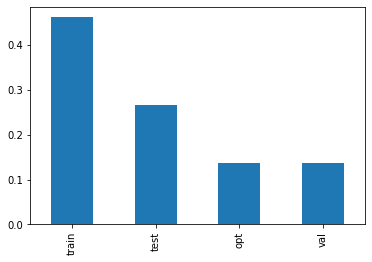

In [20]:
final_df[final_df["CLTP"] > 0]["dataset"].value_counts(normalize=True).plot.bar()

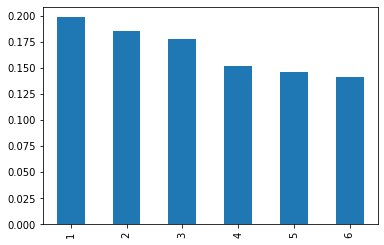

In [21]:
final_df[final_df["CLTP"] > 0]["CLTP"].value_counts(normalize=True).plot.bar()

## Guardamos los datsets

### Train

In [22]:
final_df[final_df['dataset'] == 'train'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/CLTP_train_set.feather")

### Opt

In [23]:
final_df[final_df['dataset'] == 'opt'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/CLTP_optimization_set.feather")

### Val

In [24]:
final_df[final_df['dataset'] == 'val'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/CLTP_validation_set.feather")

### Test

In [25]:
final_df[final_df['dataset'] == 'test'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/CLTP_test_set.feather")